{'state_dict': OrderedDict({'layers.0.weight': tensor([[ 4.4664e-01, -4.3010e-01, -2.5178e-01, -5.7684e-01, -1.7243e-02,
          6.8038e-01,  3.9131e-02, -8.4039e-01, -1.2045e-01,  7.5996e-01,
         -6.6085e-01, -1.6679e-01, -6.4688e-01,  8.0170e-01, -5.8400e-01,
          7.8356e-01, -1.4730e-01,  1.0996e+00],
        [ 1.4678e-01, -2.7001e-01, -3.8589e-01, -4.4566e-01,  3.1697e-01,
          5.8387e-01,  1.4595e-01,  1.4363e-01,  4.1224e-01,  2.1473e-01,
          3.0856e-01,  7.4236e-01, -5.7107e-01, -3.1331e-01, -4.2761e-01,
         -1.0635e+00,  8.0378e-02, -3.6832e-01],
        [ 4.8115e-02,  6.2005e-01,  7.3046e-01, -1.5464e-01,  3.0089e-01,
         -2.0732e-01, -6.7381e-02,  1.6518e-01, -2.1270e-01,  5.1692e-01,
         -3.8728e-01,  7.4999e-01, -5.5869e-02,  2.1801e-01, -1.6073e-01,
         -5.8743e-01,  1.4654e-01, -1.0880e+00],
        [-2.2685e-01, -5.0087e-01,  2.8635e-01,  1.8867e-01, -2.0700e-01,
          1.6701e-01, -4.4401e-01, -2.7853e-01,  2.4649e-01,  8.00

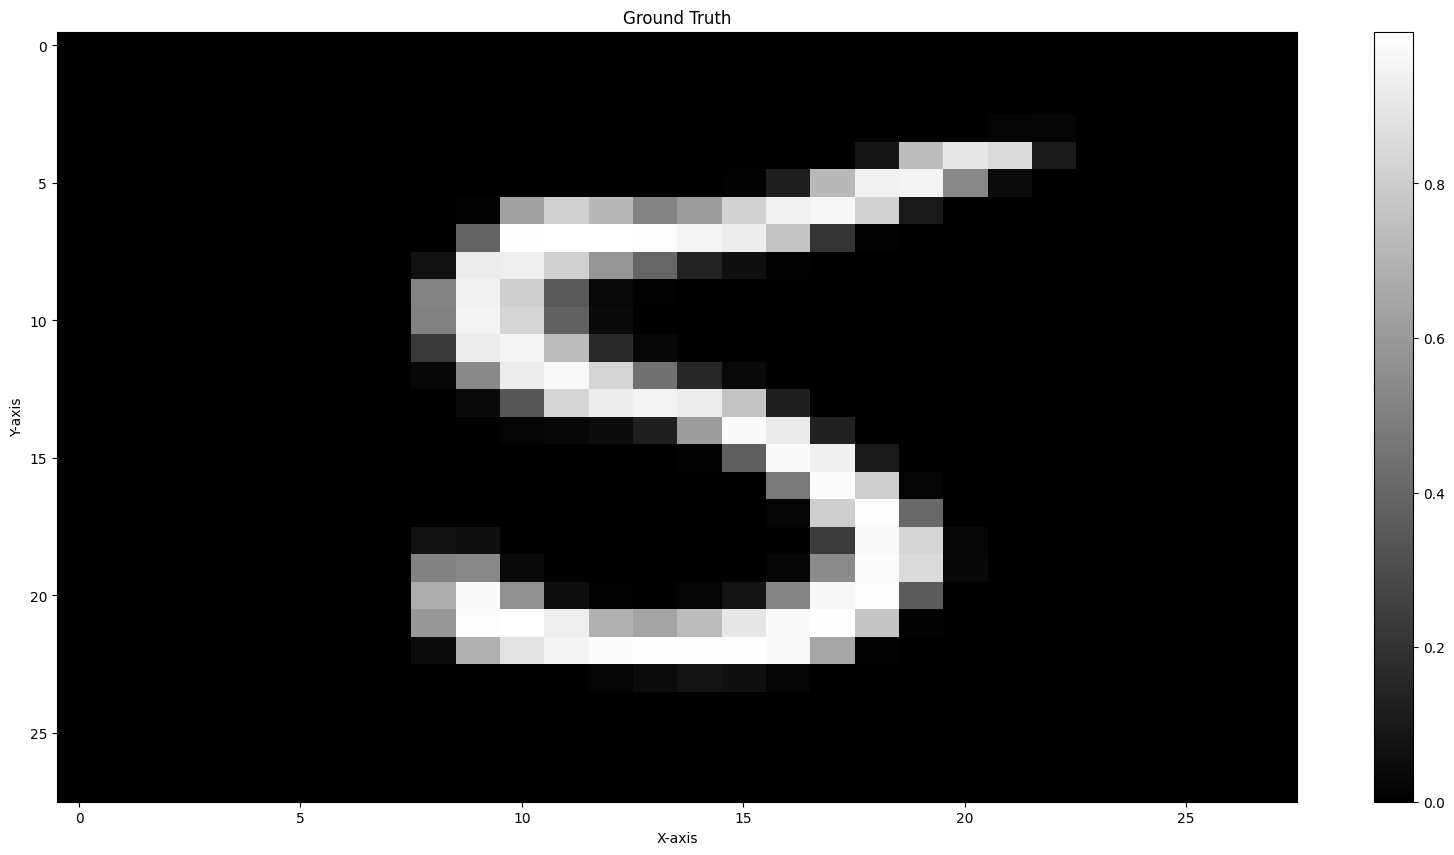

In [3]:
from data.neural_field_datasets import MnistNeFDataset, FlattenTransform, FlattenMinMaxTransform, ModelTransform
import os
import matplotlib.pyplot as plt
from animation.util import reconstruct_image

dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root_dwsnet = os.path.join(dir_path, "adl4cv", "datasets", "DWSNets", "mnist-inrs")
data_root_ours = os.path.join(dir_path, "adl4cv", "datasets", "mnist-nerfs")

idx = -1
model_dataset = MnistNeFDataset(data_root_ours, transform=ModelTransform())
flattened_dataset = MnistNeFDataset(data_root_ours, transform=FlattenTransform())

image = reconstruct_image(model_dataset[idx][0])

# Plotting the tensors as heatmaps in grayscale
fig, axes = plt.subplots(1, 1, figsize=(20, 10))

axes.imshow(image, cmap='gray', aspect='auto')
axes.set_title('Ground Truth')
axes.set_xlabel('X-axis')
axes.set_ylabel('Y-axis')

plt.colorbar(axes.imshow(image, cmap='gray', aspect='auto'), ax=axes)
plt.show()



In [ ]:
# Convert the tensor to a 1D array´
weights_1d = flattened_dataset[idx][0].numpy()

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(weights_1d, bins=500, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()